In [1454]:
# Imports:
import pandas as pd
import geopandas as gpd
from osgeo import osr, gdal
import matplotlib.pyplot as plt
import numpy as np
import georasters as gr
import seaborn as sns
sns.set_theme(style="darkgrid")
from scipy.interpolate import griddata
import rasterio
import pyproj
from rasterio.plot import show
from scipy.interpolate import griddata
import copy
import collections
import math
import pgmpy.models
import pgmpy.inference
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import ParameterEstimator
from pgmpy.inference import VariableElimination
import networkx as nx
from time import time
from shapely.geometry import Point, Polygon
from shapely.ops import cascaded_union
import networkx as nx
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate, cross_val_score

In [2]:
# Read Files/ Load Data:
vlm_df = pd.read_excel('Data/data_analisis.xls')

elevation_file = gr.from_file('Data/Elevation.TIF')
elevation_df = elevation_file.to_geopandas()
dataset = rasterio.open('Data/Elevation.tif')
elevation = dataset.read(1)

habitat_path = r"Data/UAE_habitats_new1.shp"
habitat = gpd.read_file(habitat_path)

slr_df = pd.read_excel('Data/SLR-A.xls', skiprows=15)

#note: the Elevation-Habitat map does not need to be read because it will be created and used in this notebook

# Interpolation of VLM Data:

In [3]:
vlm = vlm_df.drop(columns=['Station', 'VLM_std'])

In [4]:
# Boundary points
# Top point: max latitude
top = vlm.iloc[vlm.idxmax().Latitude]
# Bottom point: min latitude
bottom = vlm.iloc[vlm.idxmin().Latitude]
# Left point: min longitude
left = vlm.iloc[vlm.idxmin().Longitude]
# Right point: max longitude
right = vlm.iloc[vlm.idxmax().Longitude]

In [5]:
# Artificial points for calculating distances
# point = (lon, lat)
# Top counter: lon = top, lat = bottom
top_counter = (top.Longitude, bottom.Latitude)
# Bottom counter: lon = bottom, lat = top
bottom_counter = (bottom.Longitude, top.Latitude)
# Left counter: lon = right, lat = left
left_counter = (right.Longitude, left.Latitude)
# Right counter: lon = left, lat = right
right_counter = (left.Longitude, right.Latitude)

In [6]:
# Arrays for plotting
top_pair = (np.array([top.Longitude, top_counter[0]]), np.array([top.Latitude, top_counter[1]]))
bottom_pair = (np.array([bottom.Longitude, bottom_counter[0]]), np.array([bottom.Latitude, bottom_counter[1]]))
left_pair = (np.array([left.Longitude, left_counter[0]]), np.array([left.Latitude, left_counter[1]]))
right_pair = (np.array([right.Longitude, right_counter[0]]), np.array([right.Latitude, right_counter[1]]))

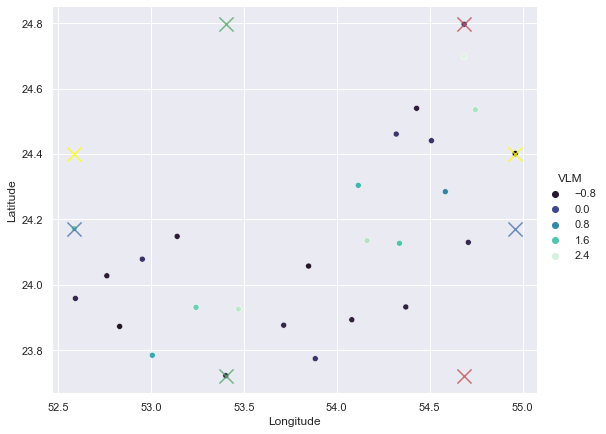

In [7]:
sns.relplot(x="Longitude", y="Latitude", hue="VLM", data=vlm, palette="mako", height=6, aspect=1.25)
plt.scatter(top_pair[0], top_pair[1], c='r', marker='x', s=200, alpha=0.8)
plt.scatter(bottom_pair[0], bottom_pair[1], c='g', marker='x', s=200, alpha=0.8)
plt.scatter(left_pair[0], left_pair[1], c='b', marker='x', s=200, alpha=0.8)
plt.scatter(right_pair[0], right_pair[1], c='yellow', marker='x', s=200, alpha=0.8)

In [8]:
from math import radians, cos, sin, asin, sqrt
def distance(lon1, lat1, lon2, lat2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in meters. Use 3956 for miles
    r = 6371*1000
      
    # calculate the result
    return(c * r)

In [9]:
# Distances of vertical pairs (top & bottom)
ver_top = distance(top.Longitude, top.Latitude, top_counter[0], top_counter[1])
ver_bottom = distance(bottom.Longitude, bottom.Latitude, bottom_counter[0], bottom_counter[1])
# Distances of horizontal pairs (left & right)
hor_left = distance(left.Longitude, left.Latitude, left_counter[0], left_counter[1])
hor_right = distance(right.Longitude, right.Latitude, right_counter[0], right_counter[1])

In [10]:
# There is some slight difference so I'm taking the rounded mean values
dis_ver = np.ceil(np.mean((ver_top, ver_bottom)))
dis_hor = np.ceil(np.mean((hor_left, hor_right)))

In [11]:
# Boundary values
x_min, x_max = vlm.min().Longitude, vlm.max().Longitude
y_min, y_max = vlm.min().Latitude, vlm.max().Latitude

In [12]:
# Divide by distance of 10m seems a bit too detailed. Trying with adding points every 100m instead
nx, ny = (np.int(np.ceil(dis_ver / 100)), np.int(np.ceil(dis_hor / 100)))
x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)
xv, yv = np.meshgrid(x, y)

<ipython-input-12-9eeb23183f3a>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nx, ny = (np.int(np.ceil(dis_ver / 100)), np.int(np.ceil(dis_hor / 100)))


In [13]:
vlm_points = vlm[['Longitude', 'Latitude']].values
vlm_values = vlm.VLM.values

In [14]:
vlm_grid = griddata(vlm_points, vlm_values, (xv, yv), method='cubic')

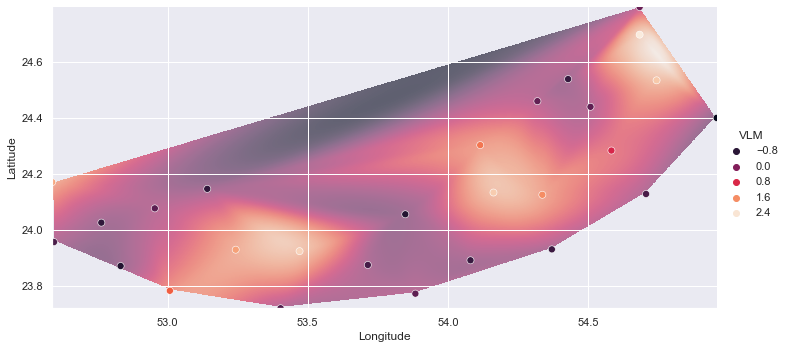

In [15]:
sns.relplot(x="Longitude", y="Latitude", hue="VLM", data=vlm, s=50, palette="rocket", height=10)
plt.imshow(vlm_grid, extent=(x_min, x_max, y_min, y_max), origin='lower', alpha=0.6)
plt.show()

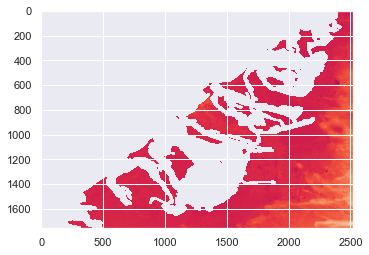

In [16]:
elevation_new = copy.deepcopy(elevation)

elevation_new = elevation_new.astype('float')
elevation_new[elevation_new == 32767] = np.nan

plt.imshow(elevation_new)

Idea: flatten the coordinate grid into pairs of coordinates to use as inputs for another interpolation

In [17]:
vlm_inter_points = np.hstack((xv.reshape(-1, 1), yv.reshape(-1, 1)))

In [18]:
vlm_inter_values = vlm_grid.flatten()

In [19]:
elev_coor = elevation_df[['x', 'y']].values

In [20]:
elev_grid_0 = griddata(vlm_points, vlm_values, elev_coor, method='cubic') # without pre-interpolation
elev_grid_1 = griddata(vlm_inter_points, vlm_inter_values, elev_coor, method='cubic') # with pre-interpolation

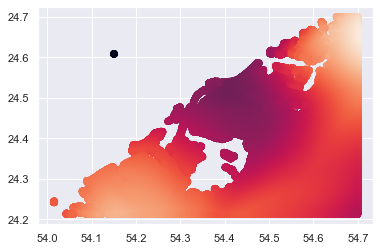

In [21]:
plt.scatter(x=elevation_df.x, y=elevation_df.y, c=elev_grid_0)

In [22]:
# Find elevation map boundaries
x_min_elev = dataset.bounds.left
x_max_elev = dataset.bounds.right
y_min_elev = dataset.bounds.bottom
y_max_elev = dataset.bounds.top

# Create elevation meshgrid
nyy, nxx = elevation_new.shape
xx = np.linspace(x_min_elev, x_max_elev, nxx)
yy = np.linspace(y_min_elev, y_max_elev, nyy)
xxv, yyv = np.meshgrid(xx, yy)

xxv.shape, yyv.shape

((1758, 2521), (1758, 2521))

elev_grid = griddata(vlm_inter_points, vlm_inter_values, (xxv, yyv), method='linear')

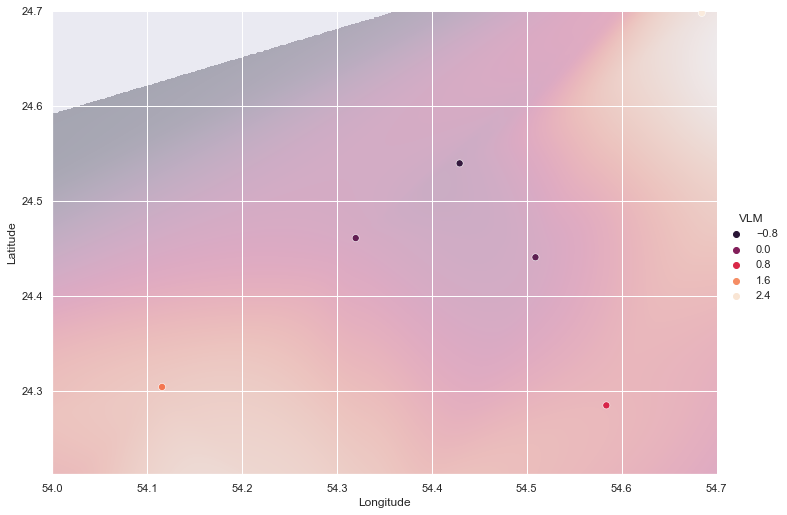

In [23]:
sns.relplot(x="Longitude", y="Latitude", hue="VLM", data=vlm, s=50, palette="rocket", height=10)
plt.imshow(elev_grid, extent=(x_min_elev, x_max_elev, y_min_elev, y_max_elev), origin="lower", alpha=0.3)
plt.show()

In [24]:
elev_grid_copy = copy.deepcopy(elev_grid)

In [25]:
elev_grid_copy[np.isnan(np.flip(elevation_new, 0))] = np.nan
# Needs to flip elevation array vertically. I don't really understand why.

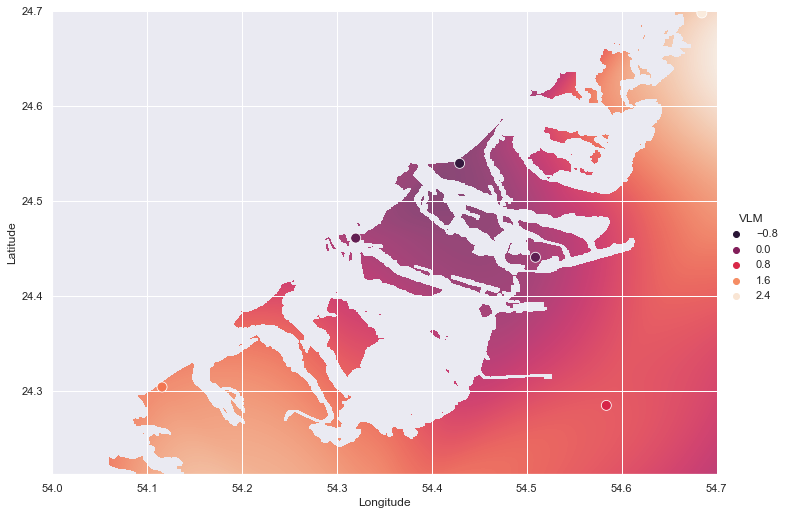

In [26]:
sns.relplot(x="Longitude", y="Latitude", hue="VLM", data=vlm, s=100, edgecolor="white", palette="rocket", height=10)
plt.imshow(elev_grid_copy, extent=(x_min_elev, x_max_elev, y_min_elev, y_max_elev), origin='lower', alpha=0.8)
plt.show()

# **the interpolated VLM values are stored in: elev_grid_copy

# Elevation-Habitat Map:

In [27]:
elevation_df.to_crs(habitat.crs, inplace=True)
elev_bounds = elevation_df.total_bounds

In [28]:
# Create boundary points
# Top left - top right - bottom right - bottom left
tl = Point(elev_bounds[0], elev_bounds[3])
tr = Point(elev_bounds[2], elev_bounds[3])
br = Point(elev_bounds[2], elev_bounds[1])
bl = Point(elev_bounds[0], elev_bounds[1])

boundary = Polygon([tl, tr, br, bl])

boundary_df = gpd.GeoSeries(boundary)

In [29]:
# Intersecting original habitat with bounding box
habitat['Intersection'] = habitat.geometry.intersects(boundary)
habitat_cut = habitat[habitat.Intersection == True]

In [30]:
t0 = time()
elev_union_shape = cascaded_union(list(elevation_df.geometry))
print("Merging elevation geometries into one polygon: %.2fs" % (time() - t0))

Merging elevation geometries into one polygon: 693.63s


In [31]:
elev_union = gpd.GeoSeries(elev_union_shape)
elev_union_df = gpd.GeoDataFrame({'geometry': elev_union})
elev_union_df.crs = habitat.crs
elev_union.crs = habitat.crs
elev_union_shape.crs = habitat.crs

In [32]:
t1 = time()
habitat_cut['Intersection_2'] = habitat_cut.geometry.intersects(elev_union_shape)
print("Intersecting reduced habitat map with elevation polygon: %.2fs" % (time() - t1))

Intersecting reduced habitat map with elevation polygon: 602.27s


/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [33]:
habitat_cut_cut = habitat_cut[habitat_cut['Intersection_2'] == True]

In [34]:
t2 = time()
final = gpd.sjoin(elevation_df, habitat_cut_cut, how="left", op="within")
print("Joining elevation df with habitat_cut_cut: %.2fs" % (time() - t2))

Joining elevation df with habitat_cut_cut: 76.74s


In [35]:
def fillna_nearest(series):
    fact = series.astype('category').factorize()

    series_cat = gpd.GeoSeries(fact[0]).replace(-1, np.nan) # get string as categorical (-1 is NaN)
    series_cat_interp = series_cat.interpolate("nearest") # interpolate categorical

    cat_to_string = {i:x for i,x in enumerate(fact[1])} # dict connecting category to string
    series_str_interp = series_cat_interp.map(cat_to_string) # turn category back to string

    return series_str_interp

In [36]:
t3 = time()
final['Fill'] = fillna_nearest(final.Habitats)
print("Interpolating missing values in final df: %.2fs" % (time() - t3))

<ipython-input-35-48fff6ddc758>:4: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  series_cat = gpd.GeoSeries(fact[0]).replace(-1, np.nan) # get string as categorical (-1 is NaN)


Interpolating missing values in final df: 1.38s


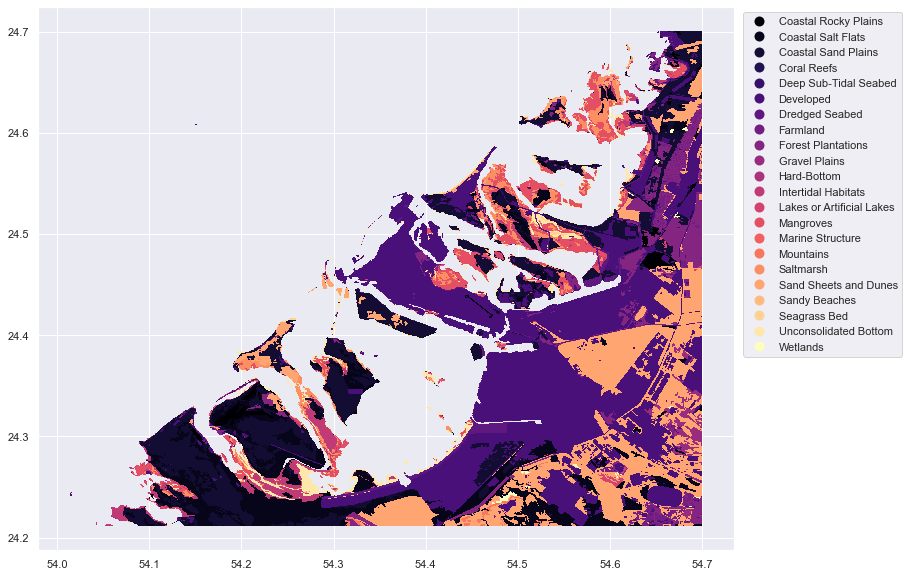

Plotting final df: 1098.58s


In [37]:
t4 = time()
f, ax = plt.subplots(1, 1, figsize=(14, 10))
ax = final.plot(column='Fill', ax=ax, legend=True, cmap='magma', edgecolor="face", linewidth=0.)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.25, 1))
plt.show()
print("Plotting final df: %.2fs" % (time() - t4))

_____________________________________________________________________________________________________________________

# Functions for clustering data:

In [38]:
def visualize_classes(df, col='Intervals'):
    counts = pd.DataFrame(df[col].value_counts())
    if col == 'Intervals':
        counts.sort_index(inplace=True)
    sns.barplot(x=counts.index, y=col, palette="mako", data=counts)
    labels = plt.xticks(rotation=45)

In [39]:
def calc_prob(df):
    d_table = pd.value_counts(df.Intervals).to_frame(name='Frequency')
    d_table = d_table.reset_index()
    d_table = d_table.rename(columns={'index': 'Class Index'})
    
    d_table['Probability'] = d_table.Frequency / d_table.Frequency.sum()
    
    return d_table

In [40]:
def calc_prob_habit(df):
    d_table = pd.value_counts(df.Values).to_frame(name='Frequency')
    d_table = d_table.reset_index()
    d_table = d_table.rename(columns={'index': 'Class Index'})
    
    d_table['Probability'] = d_table.Frequency / d_table.Frequency.sum()
    
    return d_table

In [41]:
def get_encoded_df(df, slr):
    encoded = pd.DataFrame()
    elevation_classes = encode_E(df)
    habitat_classes = encode_habitat(df)
    vlm_classes = encode_VLM(df)
    ae_classes = encode_AE(df)
    
    encoded['SLR'] = ''
    encoded['E'] = elevation_classes.Encoding
    encoded['VLM'] = vlm_classes.Encoding
    encoded['AE'] = ae_classes.Encoding
    encoded['LC'] = habitat_classes.Encoding
    encoded.SLR = slr
    
    return encoded

_____________________________________________________________________________________________________________________

# Habitats Grouping:

In [42]:
elev_habit_map = final.drop(columns=["col", "index_right", "OBJECTID", "Id", "HabitatTyp", "HabitatT_1", "HabitatSub", "HabitatS_1",
                             "RuleID", "Shape_Leng", "Shape_Area", "Habitats", "Intersection", "Intersection_2"], axis=1)

In [43]:
elev_habit_map.rename(columns={"Fill": "Habitats"}, inplace=True)

In [44]:
# Create New Column for New Habitat Groups:
elev_habit_map['Habitat_Groups'] = ''
elev_habit_map.head(1)

,row,value,x,y,geometry,Habitats,Habitat_Groups
0,0,1.0,54.651806,24.700139,"POLYGON ((54.65181 24.70014, 54.65208 24.70014...",Developed,


In [45]:
np.unique(elev_habit_map.Habitats)

array(['Coastal Rocky Plains', 'Coastal Salt Flats',
       'Coastal Sand Plains', 'Coral Reefs', 'Deep Sub-Tidal Seabed',
       'Developed', 'Dredged Seabed', 'Farmland', 'Forest Plantations',
       'Gravel Plains', 'Hard-Bottom', 'Intertidal Habitats',
       'Lakes or Artificial Lakes', 'Mangroves', 'Marine Structure',
       'Mountains', 'Saltmarsh', 'Sand Sheets and Dunes', 'Sandy Beaches',
       'Seagrass Bed', 'Unconsolidated Bottom', 'Wetlands'], dtype=object)

In [46]:
elev_habit_map.loc[ (elev_habit_map.Habitats == 'Marine Structure')
                   | (elev_habit_map.Habitats == 'Developed')
                   | (elev_habit_map.Habitats == 'Dredged Area Wall') 
                   | (elev_habit_map.Habitats == 'Dredged Seabed')
                   | (elev_habit_map.Habitats == 'Farmland') 
                   , 'Habitat_Groups'] = 'Developed'

In [47]:
elev_habit_map.loc[ (elev_habit_map.Habitats == 'Mountains')
                   | (elev_habit_map.Habitats == 'Coastal Cliff')
                   | (elev_habit_map.Habitats == 'Coastal Rocky Plains') 
                   | (elev_habit_map.Habitats == 'Gravel Plains')
                   | (elev_habit_map.Habitats == 'Rock Armouring / Artificial Reef') 
                   | (elev_habit_map.Habitats == 'Rocky Beaches')
                   | (elev_habit_map.Habitats == 'Storm Beach Ridges') 
                   , 'Habitat_Groups'] = 'Rocky'

In [48]:
elev_habit_map.loc[ (elev_habit_map.Habitats == 'Mega Dunes')
                   | (elev_habit_map.Habitats == 'Sand Sheets and Dunes')
                   | (elev_habit_map.Habitats == 'Sandy Beaches')
                   | (elev_habit_map.Habitats == 'Coastal Sand Plains')
                   , 'Habitat_Groups'] = 'Sandy'

In [49]:
elev_habit_map.loc[ (elev_habit_map.Habitats == 'Coastal Salt Flats')
                   | (elev_habit_map.Habitats == 'Inland Salt Flats')
                   | (elev_habit_map.Habitats == 'Saltmarsh')
                   | (elev_habit_map.Habitats == 'Intertidal Habitats')
                   | (elev_habit_map.Habitats == 'Wetlands')
                   , 'Habitat_Groups'] = 'Marsh/Salt Flats'

In [50]:
elev_habit_map.loc[ (elev_habit_map.Habitats == 'Coral Reefs')
                   | (elev_habit_map.Habitats == 'Deep Sub-Tidal Seabed')
                   | (elev_habit_map.Habitats == 'Hard-Bottom') 
                   | (elev_habit_map.Habitats == 'Seagrass Bed')
                   | (elev_habit_map.Habitats == 'Lakes or Artificial Lakes')
                   | (elev_habit_map.Habitats == 'Unconsolidated Bottom')
                   , 'Habitat_Groups'] = 'Subaqueous'

In [51]:
elev_habit_map.loc[ (elev_habit_map.Habitats == 'Forest Plantations')
                   | (elev_habit_map.Habitats == 'Mangroves') 
                   , 'Habitat_Groups'] = 'Forest'

In [52]:
# Be carful: it is spelled: 'Coastal Sand Plains' NOT: 'Coastal Sand Planes'
unique_groups = np.unique(elev_habit_map.Habitat_Groups)
print(unique_groups)
print(len(unique_groups))
# elev_habit_map.loc[elev_habit_map.Habitat_Groups == '']  #--> to see which rows still didnt have a group assigned to them

['Developed' 'Forest' 'Marsh/Salt Flats' 'Rocky' 'Sandy' 'Subaqueous']
6


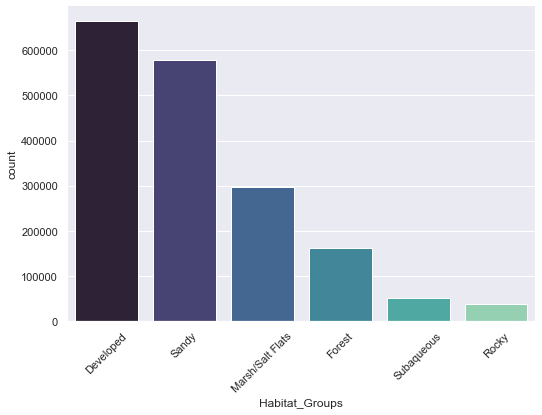

In [53]:
sns.catplot(x="Habitat_Groups", kind="count", palette="mako", data=elev_habit_map, height=5, aspect=1.5)
labels = plt.xticks(rotation=45)

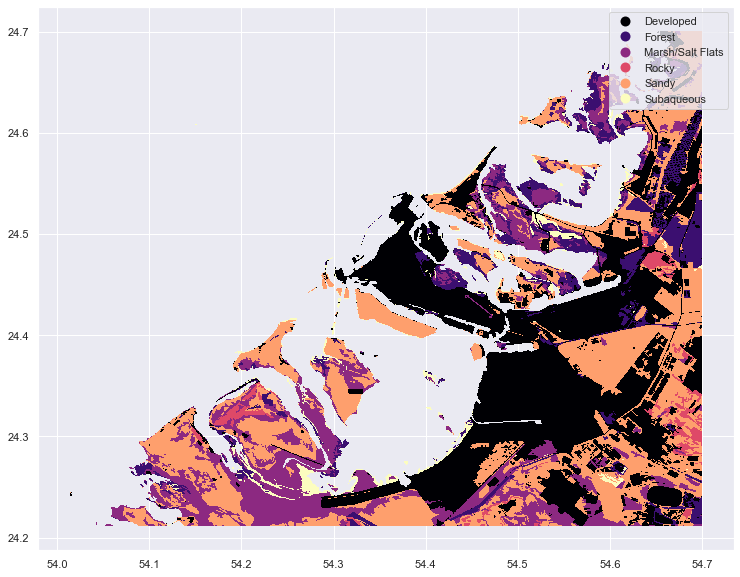

Plotting Habitat Groups: 1550.51s


In [54]:
t0 = time()
f, ax = plt.subplots(1, 1, figsize=(14, 10))
ax = elev_habit_map.plot(column='Habitat_Groups', ax=ax, legend=True, cmap='magma', edgecolor="face", linewidth=0.)
plt.show()
print("Plotting Habitat Groups: %.2fs" % (time() - t0))

# **The Elev-Habit DF now has habitat groups & it is called: 'elev_habit_map'

# Habitats Encoding:

In [55]:
def encode_habitat(df):
    h_groups = ['Subaqueous', 'Rocky', 'Marsh/Salt Flats', 'Sandy', 'Forest', 'Developed']
    h_encoding = [0, 1, 2, 3, 4, 5]
    h_df = pd.DataFrame(list(zip(h_groups, h_encoding)), columns=['Habitat_Groups', 'Encoding'])
    h_df.set_index('Habitat_Groups', inplace=True)
    h_dict = h_df.to_dict()['Encoding']
    
    habitat_classes = pd.DataFrame()
    habitat_classes['Values'] = df['Habitat_Groups']
    habitat_classes['Encoding'] = df['Habitat_Groups'].map(h_dict)
    
    # Uncomment to see which number encodes which habitat group
    for i in range(6):
        print(f"Bin #{i}, habitat: {habitat_classes[habitat_classes.Encoding == i].Values.iloc[i]}")
    
    # Uncomment to visualize classes
    visualize_classes(habitat_classes, col='Values')
    
    return habitat_classes

Bin #0, habitat: Subaqueous
Bin #1, habitat: Rocky
Bin #2, habitat: Marsh/Salt Flats
Bin #3, habitat: Sandy
Bin #4, habitat: Forest
Bin #5, habitat: Developed


,Values,Encoding
0,Developed,5
1,Developed,5
2,Developed,5
3,Developed,5
4,Developed,5
...,...,...
1789656,Marsh/Salt Flats,2
1789657,Marsh/Salt Flats,2
1789658,Marsh/Salt Flats,2
1789659,Marsh/Salt Flats,2


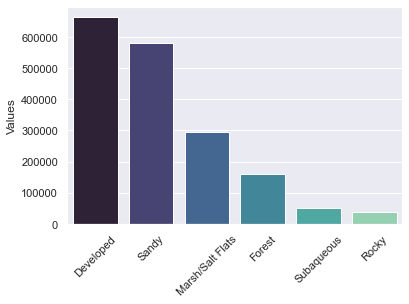

In [56]:
habitat_classes = encode_habitat(elev_habit_map)
habitat_classes

# Probabilities of Habitats:

In [57]:
habitat_types_d_table = calc_prob_habit(habitat_classes)
habitat_types_d_table

,Class Index,Frequency,Probability
0,Developed,664307,0.371192
1,Sandy,579290,0.323687
2,Marsh/Salt Flats,296326,0.165577
3,Forest,161900,0.090464
4,Subaqueous,50760,0.028363
5,Rocky,37078,0.020718


_____________________________________________________________________________________________________________________

# VLM Bins & Elevation Classes:

# 1. VLM Bins:

In [58]:
print(len(elev_grid_copy))
print(type(elev_grid_copy))
print(type(elev_grid_copy.flatten()))

1758
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [59]:
# Dropping the NaN values in the array:
nan_array = np.isnan(elev_grid_copy.flatten())
not_nan_array = ~ nan_array
vlm_interpolated_arr = elev_grid_copy.flatten()[not_nan_array]
vlm_interpolated_arr

array([1.16874389, 1.17216239, 1.17560947, ..., 2.58071978, 2.58240221,
       2.58408464])

# **The clean, flattened VLM array for interpolated VLM values is called:              
# 'vlm_interpolated_arr'

# Add VLM:

In [60]:
vlm_interpolated_arr

array([1.16874389, 1.17216239, 1.17560947, ..., 2.58071978, 2.58240221,
       2.58408464])

In [61]:
inter_vlm_df = pd.DataFrame(vlm_interpolated_arr, columns=['VLM'])

In [62]:
elev_habit_map['VLM'] = inter_vlm_df.VLM/1000

In [63]:
elev_habit_map.VLM.value_counts(dropna=False)

 0.000726    1
-0.000132    1
 0.000352    1
 0.001566    1
 0.000273    1
            ..
 0.000459    1
 0.000755    1
 0.001140    1
 0.001732    1
 0.000392    1
Name: VLM, Length: 1789661, dtype: int64

_____________________________________________________________________________________________________________________

In [64]:
def encode_VLM(df):
    vlm_classes = pd.DataFrame()
    vlm_classes['VLM_Values'] = df.VLM

    # Intervals
    vlm_intervals = pd.qcut(df.VLM, q=3)

    # Encoding
    vlm_encoding = pd.qcut(df.VLM, q=3, labels=[0, 1, 2])

    vlm_classes['Intervals'] = vlm_intervals
    vlm_classes['Encoding'] = vlm_encoding
    
    # Uncomment to see which number encodes which interval
    for i in range(3):
        print(f"Bin #{i}, interval: {vlm_classes[vlm_classes.Encoding == i].Intervals.iloc[i]}")
    
    # Uncomment to visualize classes
    visualize_classes(vlm_classes)
    
    return vlm_classes

Bin #0, interval: (-0.00322, 0.000517]
Bin #1, interval: (0.000517, 0.00102]
Bin #2, interval: (0.00102, 0.00288]


,VLM_Values,Intervals,Encoding
0,0.001169,"(0.00102, 0.00288]",2
1,0.001172,"(0.00102, 0.00288]",2
2,0.001176,"(0.00102, 0.00288]",2
3,0.001179,"(0.00102, 0.00288]",2
4,0.001183,"(0.00102, 0.00288]",2
...,...,...,...
1789656,0.002577,"(0.00102, 0.00288]",2
1789657,0.002579,"(0.00102, 0.00288]",2
1789658,0.002581,"(0.00102, 0.00288]",2
1789659,0.002582,"(0.00102, 0.00288]",2


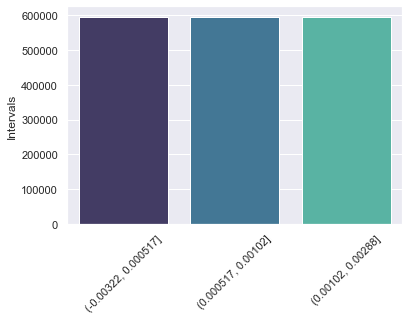

In [65]:
# Bin & encode VLM:
vlm_classes = encode_VLM(elev_habit_map)
vlm_classes

In [66]:
# Probabilities of VLM:
vlm_d_table = calc_prob(vlm_classes)
vlm_d_table

,Class Index,Frequency,Probability
0,"(-0.00322, 0.000517]",596554,0.333334
1,"(0.00102, 0.00288]",596554,0.333334
2,"(0.000517, 0.00102]",596553,0.333333


# 2. Elevation Classes grouping & encoding:

In [67]:
def encode_E(df):
    # Step 1: Create Data Frame:
    elevation_classes = pd.DataFrame()
    elevation_classes['Elevation_Values'] = df.Elevation

    # Step 2: Get Max and Min Values for Elevation
    min_elev = df.Elevation.min()
    max_elev = df.Elevation.max()

    # Step 3: Create Intervals:
    # Intervals
    interval_0 = pd.cut(x=df["Elevation"], bins=[1, 5, 10, max_elev])
    interval_1 = pd.cut(x=df["Elevation"], bins=[min_elev, -10, -1, 0], right=False)
    interval_2 = pd.cut(x=df["Elevation"], bins=[0, 1], include_lowest=True)
    # Encoding
    encoding_0 = pd.cut(x=df["Elevation"], bins=[1, 5, 10, max_elev], labels=[4, 5, 6])
    encoding_1 = pd.cut(x=df["Elevation"], bins=[min_elev, -10, -1, 0], right=False, labels=[0, 1, 2])
    encoding_2 = pd.cut(x=df["Elevation"], bins=[0, 1], include_lowest=True, labels=[3])

    # Step 4: Add intervals to dataframe:
    elevation_classes['Intervals_0'] = interval_0
    elevation_classes['Intervals_1'] = interval_1
    elevation_classes['Intervals_2'] = interval_2
    elevation_classes['Intervals'] = ''

    elevation_classes.loc[ ((elevation_classes.Intervals_0.isnull()) & (elevation_classes.Intervals_1.isnull())), 'Intervals'] = interval_2
    elevation_classes.loc[ ((elevation_classes.Intervals_0.isnull()) & (elevation_classes.Intervals_2.isnull())), 'Intervals'] = interval_1
    elevation_classes.loc[ ((elevation_classes.Intervals_1.isnull()) & (elevation_classes.Intervals_2.isnull())), 'Intervals'] = interval_0

    # Step 5: Add class encoding
    elevation_classes['Encoding_0'] = encoding_0
    elevation_classes['Encoding_1'] = encoding_1
    elevation_classes['Encoding_2'] = encoding_2
    elevation_classes['Encoding'] = ''

    elevation_classes.loc[ ((elevation_classes.Encoding_0.isnull()) & (elevation_classes.Encoding_1.isnull())), 'Encoding'] = encoding_2
    elevation_classes.loc[ ((elevation_classes.Encoding_0.isnull()) & (elevation_classes.Encoding_2.isnull())), 'Encoding'] = encoding_1
    elevation_classes.loc[ ((elevation_classes.Encoding_1.isnull()) & (elevation_classes.Encoding_2.isnull())), 'Encoding'] = encoding_0

    elevation_classes.drop(['Intervals_2', 'Intervals_1', 'Intervals_0', 'Encoding_2', 'Encoding_1', 'Encoding_0'],
                           axis='columns', inplace=True)
    
    # Uncomment to see which number encodes which interval
    for i in range(7):
        print(f"Bin #{i}, interval: {elevation_classes[elevation_classes.Encoding == i].Intervals.iloc[i]}")
        
    # Uncomment to visualize classes
    visualize_classes(elevation_classes)
    
    return elevation_classes

In [68]:
elevation_df.rename(columns = {'value':'Elevation'}, inplace = True)
elevation_df.head(1)

,row,col,Elevation,x,y,geometry
0,0,2347,1.0,54.651806,24.700139,"POLYGON ((54.65181 24.70014, 54.65208 24.70014..."


Bin #0, interval: [-89.0, -10.0)
Bin #1, interval: [-10.0, -1.0)
Bin #2, interval: [-1.0, 0.0)
Bin #3, interval: (-0.001, 1.0]
Bin #4, interval: (1.0, 5.0]
Bin #5, interval: (5.0, 10.0]
Bin #6, interval: (10.0, 83.0]


,Elevation_Values,Intervals,Encoding
0,1.0,"(-0.001, 1.0]",3
1,0.0,"(-0.001, 1.0]",3
2,1.0,"(-0.001, 1.0]",3
3,1.0,"(-0.001, 1.0]",3
4,2.0,"(1.0, 5.0]",4
...,...,...,...
1789656,37.0,"(10.0, 83.0]",6
1789657,36.0,"(10.0, 83.0]",6
1789658,37.0,"(10.0, 83.0]",6
1789659,38.0,"(10.0, 83.0]",6


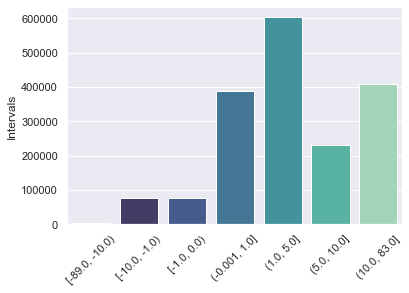

In [69]:
# Grouping & Encoding Elevation:
elevation_classes = encode_E(elevation_df)
elevation_classes

In [70]:
# Probabilities of Elevation:
elevation_d_table = calc_prob(elevation_classes)
elevation_d_table

,Class Index,Frequency,Probability
0,"(1.0, 5.0]",603235,0.337067
1,"(10.0, 83.0]",409264,0.228682
2,"(-0.001, 1.0]",389632,0.217713
3,"(5.0, 10.0]",231449,0.129326
4,"[-1.0, 0.0)",77165,0.043117
5,"[-10.0, -1.0)",76021,0.042478
6,"[-89.0, -10.0)",2895,0.001618


_____________________________________________________________________________________________________________________

# Calculating AE for SLR Scenarios:

In [71]:
elev_habit_map['Migitation 46-65'] = elev_habit_map.value - 0.27 + elev_habit_map.VLM
elev_habit_map['Intermediate 46-65'] = elev_habit_map.value - 0.3 + elev_habit_map.VLM
elev_habit_map['Intermediate-High 46-65'] = elev_habit_map.value - 0.28 + elev_habit_map.VLM
elev_habit_map['High 46-65'] = elev_habit_map.value - 0.33 + elev_habit_map.VLM
elev_habit_map.head()

,row,value,x,y,geometry,Habitats,Habitat_Groups,VLM,Migitation 46-65,Intermediate 46-65,Intermediate-High 46-65,High 46-65
0,0,1.0,54.651806,24.700139,"POLYGON ((54.65181 24.70014, 54.65208 24.70014...",Developed,Developed,0.001169,0.731169,0.701169,0.721169,0.671169
1,0,0.0,54.652084,24.700139,"POLYGON ((54.65208 24.70014, 54.65236 24.70014...",Developed,Developed,0.001172,-0.268828,-0.298828,-0.278828,-0.328828
2,0,1.0,54.652361,24.700139,"POLYGON ((54.65236 24.70014, 54.65264 24.70014...",Developed,Developed,0.001176,0.731176,0.701176,0.721176,0.671176
3,0,1.0,54.652639,24.700139,"POLYGON ((54.65264 24.70014, 54.65292 24.70014...",Developed,Developed,0.001179,0.731179,0.701179,0.721179,0.671179
4,0,2.0,54.652917,24.700139,"POLYGON ((54.65292 24.70014, 54.65319 24.70014...",Developed,Developed,0.001183,1.731183,1.701183,1.721183,1.671183


_____________________________________________________________________________________________________________________

# AE Bins & Encoding:

In [907]:
def encode_AE(df):
    # Step 1: Create Data Frame:
    ae_classes = pd.DataFrame()
    ae_classes['Values'] = df.AE

    # Step 2: Get Max and Min Values for Elevation
    min_AE = df.AE.min()
    max_AE = df.AE.max()

    # Step 3: Create Intervals:
    # Intervals
    interval_0 = pd.cut(x=df.AE, bins=[1, 5, 10, max_AE])
    interval_1 = pd.cut(x=df.AE, bins=[min_AE, -12, -1, 0], right=False)
    interval_2 = pd.cut(x=df.AE, bins=[0, 1], include_lowest=True)
    # Encoding
    encoding_0 = pd.cut(x=df.AE, bins=[1, 5, 10, max_AE], labels=[4, 5, 6])
    encoding_1 = pd.cut(x=df.AE, bins=[min_AE, -12, -1, 0], right=False, labels=[0, 1, 2])
    encoding_2 = pd.cut(x=df.AE, bins=[0, 1], include_lowest=True, labels=[3])

    # Step 4: Add intervals to dataframe:
    ae_classes['Intervals_0'] = interval_0
    ae_classes['Intervals_1'] = interval_1
    ae_classes['Intervals_2'] = interval_2
    ae_classes['Intervals'] = ''

    ae_classes.loc[ ((ae_classes.Intervals_0.isnull()) & (ae_classes.Intervals_1.isnull())), 'Intervals'] = interval_2
    ae_classes.loc[ ((ae_classes.Intervals_0.isnull()) & (ae_classes.Intervals_2.isnull())), 'Intervals'] = interval_1
    ae_classes.loc[ ((ae_classes.Intervals_1.isnull()) & (ae_classes.Intervals_2.isnull())), 'Intervals'] = interval_0

    # Step 5: Add class encoding
    ae_classes['Encoding_0'] = encoding_0
    ae_classes['Encoding_1'] = encoding_1
    ae_classes['Encoding_2'] = encoding_2
    ae_classes['Encoding'] = ''

    ae_classes.loc[ ((ae_classes.Encoding_0.isnull()) & (ae_classes.Encoding_1.isnull())), 'Encoding'] = encoding_2
    ae_classes.loc[ ((ae_classes.Encoding_0.isnull()) & (ae_classes.Encoding_2.isnull())), 'Encoding'] = encoding_1
    ae_classes.loc[ ((ae_classes.Encoding_1.isnull()) & (ae_classes.Encoding_2.isnull())), 'Encoding'] = encoding_0

    ae_classes.drop(['Intervals_2', 'Intervals_1', 'Intervals_0', 'Encoding_2', 'Encoding_1', 'Encoding_0'],
                    axis='columns', inplace=True)
    
    # Uncomment to see which number encodes which interval
    # for i in range(7):
    #     print(f"Bin #{i}, interval: {ae_classes[ae_classes.Encoding == i].Intervals.iloc[i]}")
        
    # Uncomment to visualize classes
    # visualize_classes(ae_classes)
    
    return ae_classes

In [888]:
mitigation_df = pd.DataFrame()
mitigation_df['AE'] = elev_habit_map['Migitation 46-65']

inter_df = pd.DataFrame()
inter_df['AE'] = elev_habit_map['Intermediate 46-65']

inter_high_df = pd.DataFrame()
inter_high_df['AE'] = elev_habit_map['Intermediate-High 46-65']

high_df = pd.DataFrame()
high_df['AE'] = elev_habit_map['High 46-65']

In [908]:
mit_classes = encode_AE(mitigation_df)
inter_classes = encode_AE(inter_df)
inter_high_classes = encode_AE(inter_high_df)
high_classes = encode_AE(high_df)

 22%|██▏       | 35/157 [29:33<1:43:01, 50.67s/it]


# AE Probabilities:

In [75]:
mit_d_table = calc_prob(mit_classes)
inter_d_table = calc_prob(inter_classes)
inter_high_d_table = calc_prob(inter_high_classes)
high_d_table = calc_prob(high_classes)

_____________________________________________________________________________________________________________________

# Calculating Probabilities of everything:
    probabily not going to use this:

In [76]:
# VLM:
prob_vlm = np.array(vlm_d_table.Probability).reshape(-1, 1)

In [77]:
# Elevation:
prob_elev = np.array(elevation_d_table.Probability).reshape(-1, 1)

In [78]:
# Habitats:
prob_habit = np.array(habitat_types_d_table.Probability).reshape(-1, 1)

In [79]:
# SLR:
prob_mit = np.array(mit_d_table.Probability).reshape(-1, 1)
prob_inter = np.array(mit_d_table.Probability).reshape(-1, 1)
prob_inter_high = np.array(mit_d_table.Probability).reshape(-1, 1)
prob_high = np.array(mit_d_table.Probability).reshape(-1, 1)

_____________________________________________________________________________________________________________________

# BN Model:

# 1. Prepare Data:

In [1043]:
def create_bn_df(x, df):
    pred_d = pd.DataFrame()
    pred_d['E'] = elevation_classes.Encoding
    pred_d['SLR'] = x
    pred_d['VLM'] = vlm_classes.Encoding
    pred_d['AE'] = df.Encoding
    pred_d['LC'] = habitat_classes.Encoding
    pred_d['CR_1'] = ''
    
    return pred_d

In [1044]:
# Create 4 separate df for each scenario:
predict_data_mit = create_bn_df(0, mit_classes)
predict_data_inter = create_bn_df(1, inter_classes)
predict_data_inter_high = create_bn_df(2, inter_high_classes)
predict_data_high = create_bn_df(3, high_classes)

In [1045]:
# Join all DFs:
predict_data = pd.concat([predict_data_mit, predict_data_inter, predict_data_inter_high, predict_data_high], axis=0)
predict_data = predict_data.reset_index()
predict_data = predict_data.drop(columns=['index'], axis=1)
predict_data

,E,SLR,VLM,AE,LC,CR_1
0,3,0,2,3,5,
1,3,0,2,2,5,
2,3,0,2,3,5,
3,3,0,2,3,5,
4,4,0,2,4,5,
...,...,...,...,...,...,...
7158639,6,3,2,6,2,
7158640,6,3,2,6,2,
7158641,6,3,2,6,2,
7158642,6,3,2,6,2,


# Add CR values to data frame:

In [1046]:
# 0 - static, 1 - dynamic
def add_cr(df):
    # AE = 0
    df.loc[ (df.AE == 0) & (df.LC == 0), 'CR_1'] = 1
    df.loc[ (df.AE == 0) & (df.LC == 1), 'CR_1'] = 0
    df.loc[ (df.AE == 0) & (df.LC == 2), 'CR_1'] = 0.05
    df.loc[ (df.AE == 0) & (df.LC == 3), 'CR_1'] = 0.2
    df.loc[ (df.AE == 0) & (df.LC == 4), 'CR_1'] = 0
    df.loc[ (df.AE == 0) & (df.LC == 5), 'CR_1'] = 0
    # AE = 1
    df.loc[ (df.AE == 1) & (df.LC == 0), 'CR_1'] = 0.9
    df.loc[ (df.AE == 1) & (df.LC == 1), 'CR_1'] = 0.05
    df.loc[ (df.AE == 1) & (df.LC == 2), 'CR_1'] = 0.25
    df.loc[ (df.AE == 1) & (df.LC == 3), 'CR_1'] = 0.4
    df.loc[ (df.AE == 1) & (df.LC == 4), 'CR_1'] = 0.1
    df.loc[ (df.AE == 1) & (df.LC == 5), 'CR_1'] = 0.05
    # AE = 2
    df.loc[ (df.AE == 2) & (df.LC == 0), 'CR_1'] = 0.7
    df.loc[ (df.AE == 2) & (df.LC == 1), 'CR_1'] = 0.1
    df.loc[ (df.AE == 2) & (df.LC == 2), 'CR_1'] = 0.45
    df.loc[ (df.AE == 2) & (df.LC == 3), 'CR_1'] = 0.85
    df.loc[ (df.AE == 2) & (df.LC == 4), 'CR_1'] = 0.45
    df.loc[ (df.AE == 2) & (df.LC == 5), 'CR_1'] = 0.25
    # AE = 3
    df.loc[ (df.AE == 3) & (df.LC == 0), 'CR_1'] = 0.5
    df.loc[ (df.AE == 3) & (df.LC == 1), 'CR_1'] = 0.5
    df.loc[ (df.AE == 3) & (df.LC == 2), 'CR_1'] = 0.65
    df.loc[ (df.AE == 3) & (df.LC == 3), 'CR_1'] = 0.95
    df.loc[ (df.AE == 3) & (df.LC == 4), 'CR_1'] = 0.5
    df.loc[ (df.AE == 3) & (df.LC == 5), 'CR_1'] = 0.5
    # AE = 4
    df.loc[ (df.AE == 4) & (df.LC == 0), 'CR_1'] = 0.1
    df.loc[ (df.AE == 4) & (df.LC == 1), 'CR_1'] = 0.9
    df.loc[ (df.AE == 4) & (df.LC == 2), 'CR_1'] = 0.9
    df.loc[ (df.AE == 4) & (df.LC == 3), 'CR_1'] = 1
    df.loc[ (df.AE == 4) & (df.LC == 4), 'CR_1'] = 0.75
    df.loc[ (df.AE == 4) & (df.LC == 5), 'CR_1'] = 0.75
    # AE = 5
    df.loc[ (df.AE == 5) & (df.LC == 0), 'CR_1'] = 0
    df.loc[ (df.AE == 5) & (df.LC == 1), 'CR_1'] = 1
    df.loc[ (df.AE == 5) & (df.LC == 2), 'CR_1'] = 1
    df.loc[ (df.AE == 5) & (df.LC == 3), 'CR_1'] = 1
    df.loc[ (df.AE == 5) & (df.LC == 4), 'CR_1'] = 0.95
    df.loc[ (df.AE == 5) & (df.LC == 5), 'CR_1'] = 0.95
    # AE = 6
    df.loc[ (df.AE == 6) & (df.LC == 0), 'CR_1'] = 0
    df.loc[ (df.AE == 6) & (df.LC == 1), 'CR_1'] = 1
    df.loc[ (df.AE == 6) & (df.LC == 2), 'CR_1'] = 1
    df.loc[ (df.AE == 6) & (df.LC == 3), 'CR_1'] = 1
    df.loc[ (df.AE == 6) & (df.LC == 4), 'CR_1'] = 1
    df.loc[ (df.AE == 6) & (df.LC == 5), 'CR_1'] = 1
    
    return df

In [1047]:
predict_data = add_cr(predict_data)
predict_data

,E,SLR,VLM,AE,LC,CR_1
0,3,0,2,3,5,0.5
1,3,0,2,2,5,0.25
2,3,0,2,3,5,0.5
3,3,0,2,3,5,0.5
4,4,0,2,4,5,0.75
...,...,...,...,...,...,...
7158639,6,3,2,6,2,1
7158640,6,3,2,6,2,1
7158641,6,3,2,6,2,1
7158642,6,3,2,6,2,1


# Encode CR:

In [1050]:
def encode_cr(df):
    df['CR_1_Encoded'] = ''
    
    df.loc[ df.CR_1 == 0, 'CR_1_Encoded'] = 1
    df.loc[ df.CR_1 == 1, 'CR_1_Encoded'] = 0
    df.loc[ df.CR_1 == 0.05, 'CR_1_Encoded'] = 2
    df.loc[ df.CR_1 == 0.2, 'CR_1_Encoded'] = 3
    df.loc[ df.CR_1 == 0.9, 'CR_1_Encoded'] = 4
    df.loc[ df.CR_1 == 0.25, 'CR_1_Encoded'] = 5
    df.loc[ df.CR_1 == 0.4, 'CR_1_Encoded'] = 6
    df.loc[ df.CR_1 == 0.1, 'CR_1_Encoded'] = 7
    df.loc[ df.CR_1 == 0.7, 'CR_1_Encoded'] = 8
    df.loc[ df.CR_1 == 0.45, 'CR_1_Encoded'] = 9
    df.loc[ df.CR_1 == 0.85, 'CR_1_Encoded'] = 10
    df.loc[ df.CR_1 == 0.5, 'CR_1_Encoded'] = 11
    df.loc[ df.CR_1 == 0.65, 'CR_1_Encoded'] = 12
    df.loc[ df.CR_1 == 0.95, 'CR_1_Encoded'] = 13
    df.loc[ df.CR_1 == 0.75, 'CR_1_Encoded'] = 14
    
    df = df.drop(columns = ['CR_1'], axis=1)
    df = df.rename(columns = {'CR_1_Encoded': 'CR_1'}, inplace = False)
    
    return df

In [1051]:
predict_data = encode_cr(predict_data)

In [1052]:
predict_data

,E,SLR,VLM,AE,LC,CR_1
0,3,0,2,3,5,11
1,3,0,2,2,5,5
2,3,0,2,3,5,11
3,3,0,2,3,5,11
4,4,0,2,4,5,14
...,...,...,...,...,...,...
7158639,6,3,2,6,2,0
7158640,6,3,2,6,2,0
7158641,6,3,2,6,2,0
7158642,6,3,2,6,2,0


# Decode:

In [1064]:
def decode_cr(df):
    df['CR_1_Dec'] = ''
    
    df.loc[ df.CR_1 == 0, 'CR_1_Dec'] = 1
    df.loc[ df.CR_1 == 1, 'CR_1_Dec'] = 0
    df.loc[ df.CR_1 == 2, 'CR_1_Dec'] = 0.05
    df.loc[ df.CR_1 == 3, 'CR_1_Dec'] = 0.2
    df.loc[ df.CR_1 == 4, 'CR_1_Dec'] = 0.9
    df.loc[ df.CR_1 == 5, 'CR_1_Dec'] = 0.25
    df.loc[ df.CR_1 == 6, 'CR_1_Dec'] = 0.4 
    df.loc[ df.CR_1 == 7, 'CR_1_Dec'] = 0.1
    df.loc[ df.CR_1 == 8, 'CR_1_Dec'] = 0.7
    df.loc[ df.CR_1 == 9, 'CR_1_Dec'] = 0.45
    df.loc[ df.CR_1 == 10, 'CR_1_Dec'] = 0.85
    df.loc[ df.CR_1 == 11, 'CR_1_Dec'] = 0.5
    df.loc[ df.CR_1 == 12, 'CR_1_Dec'] = 0.65
    df.loc[ df.CR_1 == 13, 'CR_1_Dec'] = 0.95
    df.loc[ df.CR_1 == 14, 'CR_1_Dec'] = 0.75
    
    df = df.drop(columns = ['CR_1'], axis=1)
    df = df.rename(columns = {'CR_1_Dec': 'CR_1'}, inplace = False)
    
    return df

# 2. Model Structure:

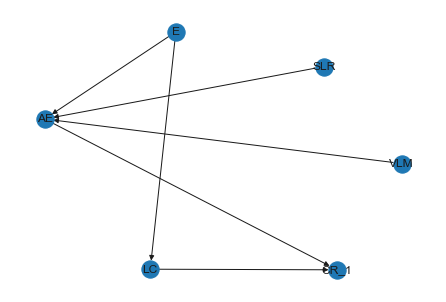

In [1462]:
model = pgmpy.models.BayesianModel([('SLR', 'AE'),
                           ('VLM', 'AE'),
                           ('E', 'AE'),
                           ('E', 'LC'),
                           ('LC', 'CR_1'),
                           ('AE', 'CR_1')])
nx.draw(model, with_labels=True)

_____________________________________________________________________________________________________________________

# 3. Training & Testing the Model:

In [1055]:
# Split Data Set:
x_train, x_test = train_test_split(predict_data, test_size=0.9999)

In [1056]:
print(x_train.CR_1.unique())
print(x_test.CR_1.unique())

[12 11 2 5 4 13 8 0 6 14 9 7 10 1]
[6 0 7 14 4 11 5 13 9 10 2 12 8 1 3]


In [1057]:
# Train model on x_train dataset:
model.fit(x_train, estimator=BayesianEstimator, prior_type="BDeu")

In [1058]:
# Test on x_test:
t0 = time()
to_be_predicted_data = x_test.drop(columns=['CR_1'], axis=1)
y_pred = model.predict(to_be_predicted_data)
print("Making predictions: %.2fs" % (time() - t0))

100%|██████████| 628/628 [00:45<00:00, 13.71it/s]


Making predictions: 51.20s


In [1059]:
print(sklearn.metrics.accuracy_score(y_pred.CR_1.values, x_test.CR_1.values.astype('int')))

0.9987437707191563


In [1065]:
# Decode CR in y_pred:
y_pred = decode_cr(y_pred)

# Plotting predictions for Mitigation scenario:

In [1357]:
# Mit:
p = create_bn_df(0, mit_classes)
p = add_cr(p)
p = encode_cr(p)

In [1358]:
p_train, p_test = train_test_split(p, test_size=0.9999)

In [1359]:
model.fit(p_train, estimator=BayesianEstimator, prior_type="BDeu")

In [1360]:
t0 = time()
to_be_predicted_data = p.drop(columns=['CR_1'], axis=1)
p_pred = model.predict(to_be_predicted_data)
print("Making predictions: %.2fs" % (time() - t0))

100%|██████████| 157/157 [00:08<00:00, 17.74it/s]


Making predictions: 10.45s


In [1361]:
print(sklearn.metrics.accuracy_score(p_pred.CR_1.values.astype('int'), p.CR_1.values.astype('int')))

0.9900919783132113


In [1362]:
p_pred = decode_cr(p_pred)

In [1363]:
df = elev_habit_map[['geometry']]
df['CR_1'] = p_pred['CR_1']
df.head(1)

/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,geometry,CR_1
0,"POLYGON ((54.65181 24.70014, 54.65208 24.70014...",0.5


Plot:

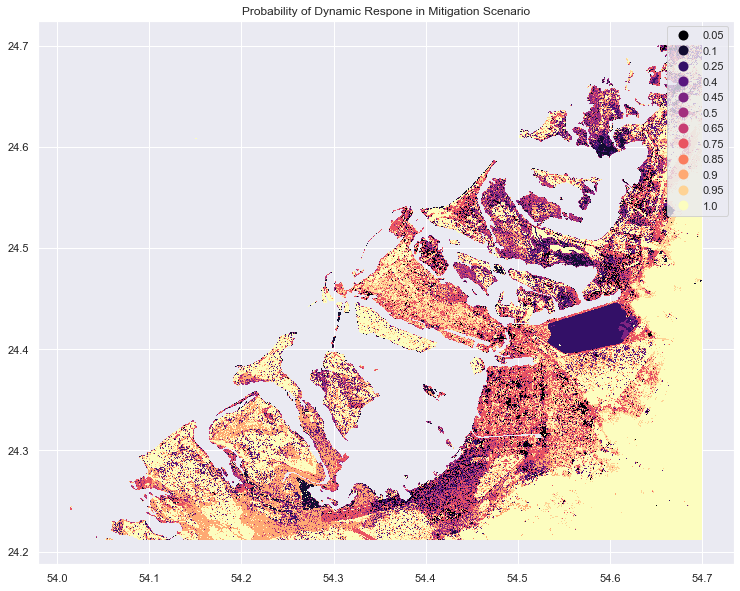

In [1364]:
f, ax = plt.subplots(1, 1, figsize=(14, 10))
ax = df.plot(column='CR_1', ax=ax, legend=True, cmap='magma', edgecolor="face", linewidth=0.)
plt.title('Probability of Dynamic Respone in Mitigation Scenario')
plt.show()

# Anomaly Plot:

In [1174]:
dif_df = pd.DataFrame()
dif_df['Pred_CR'] = p_pred['CR_1']
dif_df['OG_CR'] = decode_cr(p)['CR_1']
dif_df['Difference'] = dif_df['OG_CR'] - dif_df['Pred_CR']

In [1175]:
dif_df.Difference.value_counts()

 0.00    1773457
-0.10       7146
-1.00       4329
-0.05       1408
-0.50       1037
-0.95        748
-0.90        623
-0.20        608
-0.10        267
 0.10         38
Name: Difference, dtype: int64

In [1176]:
dif_df['Encoded_Difference'] = ''
dif_df.loc[ dif_df.Difference < 0, 'Encoded_Difference'] = 0  # negative
dif_df.loc[ dif_df.Difference == 0, 'Encoded_Difference'] = 1 # 0 
dif_df.loc[ dif_df.Difference > 0, 'Encoded_Difference'] = 2  # positive

In [1179]:
df['Encoded_Difference'] = dif_df['Encoded_Difference']

/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


https://matplotlib.org/stable/tutorials/colors/colormaps.html
Daiane Faller to Everyone (7:33 PM)
https://matplotlib.org/cmocean/

# Trying to predict AE and CR:

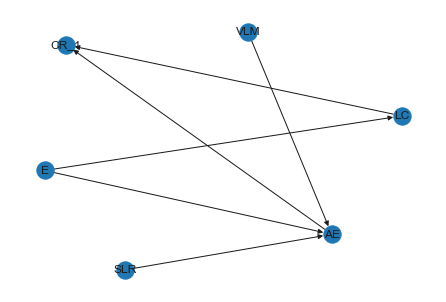

In [1404]:
model_ae = pgmpy.models.BayesianModel([('SLR', 'AE'),
                           ('VLM', 'AE'),
                           ('E', 'AE'),
                           ('E', 'LC'),
                           ('LC', 'CR_1'),
                           ('AE', 'CR_1')])
nx.draw(model_ae, with_labels=True)

In [1405]:
p = create_bn_df(0, mit_classes)
p = add_cr(p)
p = encode_cr(p)

In [1410]:
# Split Data Set:
x_train, x_test = train_test_split(p, test_size=0.99999)

In [1411]:
print(x_train.CR_1.unique())
print(x_test.CR_1.unique())

[13 0 14 12 9 11 4 5 7]
[0 12 4 13 14 5 7 10 2 6 11 9 8 1 3]


In [1412]:
# Train model on x_train dataset:
model_ae.fit(x_train, estimator=BayesianEstimator, prior_type="BDeu")

In [1413]:
# Test on x_test:
t0 = time()
to_be_predicted_data = p.drop(columns=['AE','CR_1'], axis=1)
y_pred_new = model_ae.predict(to_be_predicted_data)
print("Making predictions: %.2fs" % (time() - t0))

100%|██████████| 125/125 [00:05<00:00, 23.58it/s]


Making predictions: 6.62s


In [1414]:
print('When I predict both AE and CR, the accuracies are as follows: ')
print(sklearn.metrics.accuracy_score(y_pred_new.AE.values, p.AE.values.astype('int')))
print(sklearn.metrics.accuracy_score(y_pred_new.CR_1.values, p.CR_1.values.astype('int')))

When I predict both AE and CR, the accuracies are as follows: 
0.7109893996684288
0.6847978471900544


In [1415]:
dif_df_ae = pd.DataFrame()
dif_df_ae['OG_CR'] = decode_cr(p)['CR_1']
dif_df_ae['Pred_CR'] = decode_cr(y_pred_new)['CR_1']
dif_df_ae['Difference'] = dif_df_ae['OG_CR'] - dif_df_ae['Pred_CR']

In [1416]:
dif_df_ae['Encoded_Difference'] = ''
dif_df_ae.loc[ dif_df_ae.Difference < 0, 'Encoded_Difference'] = 'Negative (Below)'  # negative
dif_df_ae.loc[ dif_df_ae.Difference == 0, 'Encoded_Difference'] = 'Zero (Accurate)' # 0 
dif_df_ae.loc[ dif_df_ae.Difference > 0, 'Encoded_Difference'] = 'Positive (Higher)'  # positive

In [1417]:
df = elev_habit_map[['geometry']]
df['Encoded_Difference'] = dif_df_ae['Encoded_Difference']
df

/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,geometry,Encoded_Difference
0,"POLYGON ((54.65181 24.70014, 54.65208 24.70014...",Positive (Higher)
1,"POLYGON ((54.65208 24.70014, 54.65236 24.70014...",Zero (Accurate)
2,"POLYGON ((54.65236 24.70014, 54.65264 24.70014...",Positive (Higher)
3,"POLYGON ((54.65264 24.70014, 54.65292 24.70014...",Positive (Higher)
4,"POLYGON ((54.65292 24.70014, 54.65319 24.70014...",Zero (Accurate)
...,...,...
1789656,"POLYGON ((54.69875 24.21208, 54.69903 24.21208...",Zero (Accurate)
1789657,"POLYGON ((54.69903 24.21208, 54.69931 24.21208...",Zero (Accurate)
1789658,"POLYGON ((54.69931 24.21208, 54.69958 24.21208...",Zero (Accurate)
1789659,"POLYGON ((54.69958 24.21208, 54.69986 24.21208...",Zero (Accurate)


In [1418]:
df.Encoded_Difference.value_counts()

Zero (Accurate)      1225556
Negative (Below)      389501
Positive (Higher)     174604
Name: Encoded_Difference, dtype: int64

/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


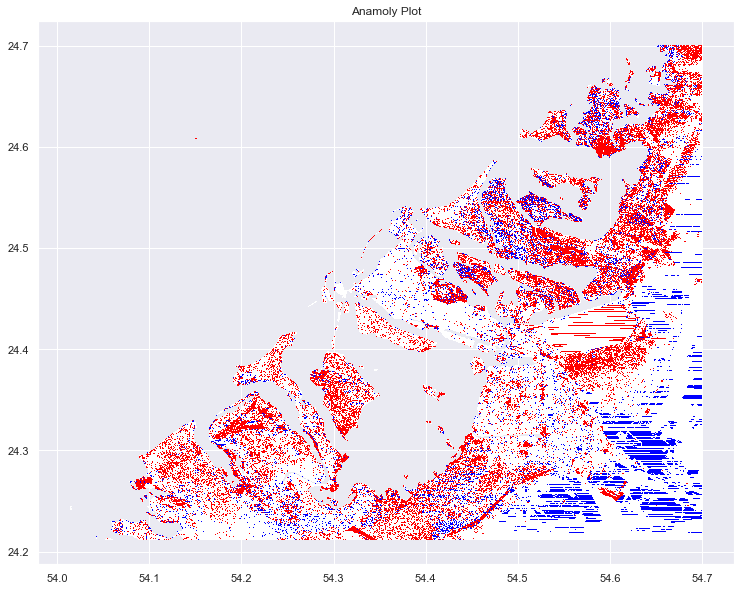

In [1419]:
color_id = {'Zero (Accurate)': 'white', 'Negative (Below)': 'red', 'Positive (Higher)': 'blue'}
color_map = [color_id[var] for var in df.Encoded_Difference]

f, ax = plt.subplots(1, 1, figsize=(14, 10))
ax = df.plot(column='Encoded_Difference', ax=ax, legend=True, color=color_map, edgecolor="face", linewidth=0.)
plt.title('Anamoly Plot')
plt.show()

# K-Fold Cross Validation:

In [1440]:
def partition(data, n):
    splits = []
    remaining = data.copy(deep=True)
    for i in range(n):
        split = remaining.sample(frac=1/(n-i), random_state=10)
        splits.append(split)
        remaining = remaining.drop(split.index)
    return splits

In [1459]:
def cross_val(model, data, n, target):
    scores = []
    splits = partition(data, n)
    for i in range(n):
        train_list = splits[:i] + splits[i+1:]
        train = pd.concat(train_list)
        test = splits[i]
        y_true = test[target]
        test = test.drop(columns=[target, 'AE'], axis=1)
        model.fit(train, estimator=BayesianEstimator, prior_type="BDeu")
        y_pred = model.predict(test)
        acc = accuracy_score(y_pred[target], y_true.astype('int'))
        scores.append(acc)
    return scores

In [1463]:
scores = cross_val(model, p.drop(columns=['CR_1_Dec'], axis=1), 10, target="CR_1")
print("Mean score:", np.mean(scores))
scores

100%|██████████| 123/123 [00:03<00:00, 32.71it/s]


Mean score: 0.8967262514062064


[0.8972709900204509,
 0.8962708000402311,
 0.897164824603556,
 0.896706637014852,
 0.8964831308740208,
 0.8969636690768079,
 0.8964160790317715,
 0.8963657901500843,
 0.8967122246683727,
 0.8969083685819174]

# Random:

In [ ]:
new_row = {'E':3, 'SLR':2, 'VLM':1, 'AE':6, 'LC':2, 'CR_1':0}
new_row2 = {'E':3, 'SLR':2, 'VLM':1, 'AE':6, 'LC':0, 'CR_1':1}
#append row to the dataframe
x_train = x_train.append(new_row, ignore_index=True)
x_train = x_train.append(new_row2, ignore_index=True)

x_test["AE"].replace({4: 6}, inplace=True)

print(x_train.CR_1.unique())
print(x_test.CR_1.unique())